In [1]:
# get the paths to the code sorted out.  This is the wrong way to do it, and it needs sorting out as to the correct way
# Might need pip install developer mode so that a symlink is made to the databakersolo source code from the git checkout
# rather than it being copied deep into the site-packages directory tree
import sys
sys.path.insert(0, "/home/goatchurch/sensiblecode/databaker")
sys.path.insert(0, "/home/goatchurch/sensiblecode/xypath")
sys.path.insert(0, "/home/goatchurch/sensiblecode/messytables")
sys.path.insert(0, "/home/goatchurch/datalogging/anaconda3/lib/python3.5/site-packages/")  # for xlrd
sys.path.insert(0, "/home/goatchurch/datalogging/anaconda3/lib/python3.5/site-packages/xlutils-2.0.0-py3.5.egg/")  # for xlutils
import databaker
import databaker.constants
from databaker.constants import *
import xlutils
import xypath
import databaker.databakersolo as ds


In [13]:
tableset = xypath.loader.table_set("rftmatables_tcm77-415727.xls", extension='xls')
tabs = list(xypath.loader.get_sheets(tableset, "*"))   

conversionsegments = [ ]
for tab in tabs:
    if tab.name == "Table 1":
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        dimensions = [
            (anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            (anchor.expand(RIGHT).parent().is_not_blank(), 'Companies', CLOSEST, LEFT),
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT),
            (anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank(), 'Transaction', CLOSEST, LEFT),
            (anchor.expand(DOWN).is_not_blank().is_bold(), 'TIMETYPE', CLOSEST, ABOVE)   
        ]
        conversionsegments.append((tab, dimensions, obs))
        
    elif tab.name in ['Table 2', 'Table 3', 'Table 4', 'Table 5']:
        anchor = tab.excel_ref('B3')
        obs = anchor.shift(0, 5).fill(RIGHT).expand(DOWN).is_not_blank()

        unwanted = tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)      
        unwanted = unwanted | tab.excel_ref('V1').expand(RIGHT).expand(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Number')).shift(RIGHT).fill(DOWN)
        unwanted = unwanted | tab.filter(contains_string ('Value')).shift(RIGHT).fill(DOWN)
        obs = obs - unwanted       

        inv1 = anchor.shift(DOWN).expand(RIGHT).parent().is_not_blank()
        inv1 = inv1 | tab.excel_ref('B4')
        inv1.dimension('Investment', CLOSEST, LEFT)

        dimensions = [
            (anchor.expand(DOWN).is_not_blank().is_not_bold(), TIME, DIRECTLY, LEFT),
            (anchor.expand(RIGHT).parent().is_not_blank(), 'Category', CLOSEST, LEFT), 
            (inv1, 'Investment', CLOSEST, LEFT), 
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), MEASURETYPE, CLOSEST, LEFT), 
            (tab.excel_ref('C1'), 'Category', CLOSEST, ABOVE), 
            (anchor.shift(0, 2).expand(RIGHT).parent().is_not_blank(), "Measure", CLOSEST, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 6", "Table 7"]:
        
        my_dict = {"6A_Top": 'CBAQ', "6A_Bottom": 'HCL3', "6D_Top": 'CBAS', "6D_Bottom":'HCL5',
                   "7A_Top": 'CBAU', "7A_Bottom": 'HCK7', "7D_Top": 'CBAW', "7D_Bottom":'HCK9'  }
        for P1, corner in my_dict.items():
            if P1[0] != tab.name[-1]:
                continue
    
            anchor = tab.filter(contains_string(corner))
            obs = anchor.shift(DOWN).expand(RIGHT).expand(DOWN).is_not_blank()

            # Getting all the junk out of the file
            unwanted = tab.excel_ref('AA1').expand(DOWN).expand(RIGHT)     
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Area Analysis')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
            unwanted = unwanted | anchor.expand(DOWN).filter(contains_string ('Number')).shift(UP).expand(RIGHT).expand(DOWN)
            obs = obs - unwanted    
            cat = tab.filter(contains_string(P1[0:2])).shift(RIGHT)
            dimensions = [
                (anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Area", CLOSEST, LEFT), 
                (anchor.shift(0, -1).expand(RIGHT).is_not_blank(), MEASURETYPE, DIRECTLY, ABOVE), 
                (anchor.shift(-1, 0).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT),
                (cat, "Mergers", CLOSEST, ABOVE)
            ]
            conversionsegments.append((tab, dimensions, obs))

    elif tab.name in ["Table 8", "Table 10"]:
        anchor = tab.excel_ref('C3')
        
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref('R1').expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ('indicates earliest revision')).expand(RIGHT).expand(DOWN)
        measure_line = anchor.shift(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - measure_line.shift(RIGHT).expand(DOWN)
        
        dimensions = [
            (anchor.expand(RIGHT).is_not_blank(), "Category", CLOSEST, LEFT), 
            (measure_line, MEASURETYPE, DIRECTLY, ABOVE), 
            (anchor.shift(LEFT).expand(DOWN).is_bold(), "TIME - DELETEME", CLOSEST, ABOVE), 
            (anchor.shift(LEFT).expand(DOWN).is_not_bold().is_not_blank(), TIME, DIRECTLY, LEFT)
        ]
        conversionsegments.append((tab, dimensions, obs))
    
    elif tab.name in ["Table 9"]:
        anchor = tab.filter(contains_string ('Total')).assert_one()

        dimensions = [ 
            (anchor.shift(0, -2).expand(RIGHT).is_not_blank(), "Expenditure", CLOSEST, LEFT), 
            (anchor.shift(0, -1).expand(RIGHT).is_not_blank(), "Expenditure 1", CLOSEST, LEFT),  # this is the one that wants to be left or right above
            (anchor.expand(RIGHT).is_not_blank(), "Expenditure 2", CLOSEST, LEFT), 
            (anchor.shift(LEFT).expand(DOWN).is_not_blank(), TIME, DIRECTLY, LEFT), 
            (anchor.shift(LEFT).expand(DOWN).is_bold(), "ExtraTime", CLOSEST, ABOVE), 
        ]
        # Get obs,and get rid of lots of crap    
        obs = anchor.shift(0, 2).fill(DOWN).expand(RIGHT).is_not_blank()
        obs = obs - tab.excel_ref("V1").expand(DOWN).expand(RIGHT)
        obs = obs - tab.filter(contains_string ("earliest revision")).expand(RIGHT).expand(DOWN)
        obs = obs - anchor.expand(RIGHT).is_not_blank().shift(RIGHT).fill(DOWN)
        conversionsegments.append((tab, dimensions, obs))

            
print(len(conversionsegments))
print([c[0].name for c in conversionsegments])

got header Investment: 392.734s,  743.910s total
got header Investment: 0.020s,  743.930s total
got header Investment: 0.018s,  743.948s total
got header Investment: 0.017s,  743.965s total
16
['Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5', 'Table 6', 'Table 6', 'Table 6', 'Table 6', 'Table 7', 'Table 7', 'Table 7', 'Table 7', 'Table 8', 'Table 9', 'Table 10']


In [25]:
# capability to plot the individual conversion segments (maybe externally into a different window on a second screen?)
import databaker.jupybakeutils
tab, dimensions, segment = conversionsegments[14]
databaker.jupybakeutils.displaytable(tab, databaker.jupybakeutils.dsubsets(dimensions, segment))


OBS,Expenditure,Expenditure 1,Expenditure 2,TIME,ExtraTime


,9.0,Mergers and Acquisitions in the UK by other UK Companies: Category of Expenditure,,,,,,,,,,,,,,,,,,,,,,
,£ million,,,,,,,,,,,,,,,,,,,,,,,
,,Expenditure,,,,,,,,,,,,,Percentage of Expenditure,,,,,,,,,
,,,,Cash,,,,,,,,,,,,,,,,,,,,
,,Total,,Independent Companies,,,Subsidiaries,,,Issues of Ordinary Shares²,,Issues of Fixed Interest Securities²,,,Cash,,Issues of Ordinary Shares,,Issues of Fixed Interest Securities,,,,,
,,DUCM,,DWVW,,,DWVX,,,AIHD,,AIHE,,,DWVY,,DWVZ,,DWWA,,,,,
,Annual,,,,,,,,,,,,,,,,,,,,,,,
,2003.0,18679.0,,8956.0,,,7183.0,,,1667.0,,873.0,,,86.0,,9.0,,5.0,,,,,
,2004.0,31408.0,,12080.0,,,7822.0,,,10338.0,,1168.0,,,63.0,,33.0,,4.0,,,,,
,2005.0,25134.0,,13425.0,,,8510.0,,,2768.0,,431.0,,,87.0,,11.0,,2.0,,,,,
,2006.0,28511.0,,..,,,8131.0,,,..,,335.0,,,..,,..,,2.0,,,,,


In [17]:

# convert the segments and handle the messy cases, eg 2010^2 and missing values
allvalues = [ ]
for tab, dimensions, segment in conversionsegments:
    print(tab.name, [d[1]  for d in dimensions])
    for ob in segment:
        v = { OBS:ob.value }
        for header_bag, name, strict, direction in dimensions:
            v[name] = ds.overrides.Dcelllookup(header_bag, direction, strict, None, ob).value
        if isinstance(v[TIME], str):
            v[TIME] = int(v[TIME][:4])
        if isinstance(v[OBS], str):
            continue
        allvalues.append(v)

# In theory we can now call the template export to big CSV, like before at this point
# But now we should seek to plot the stats ourselves as a sanity check that the data is good
        

len(allvalues), allvalues[-1]

Table 1 [-2, 'Companies', -6, 'Transaction', 'TIMETYPE']
Table 2 [-2, 'Category', 'Investment', -6, 'Category', 'Measure']
Table 3 [-2, 'Category', 'Investment', -6, 'Category', 'Measure']
Table 4 [-2, 'Category', 'Investment', -6, 'Category', 'Measure']
Table 5 [-2, 'Category', 'Investment', -6, 'Category', 'Measure']
Table 6 ['Area', -6, -2, 'Mergers']
Table 6 ['Area', -6, -2, 'Mergers']
Table 6 ['Area', -6, -2, 'Mergers']
Table 6 ['Area', -6, -2, 'Mergers']
Table 7 ['Area', -6, -2, 'Mergers']
Table 7 ['Area', -6, -2, 'Mergers']
Table 7 ['Area', -6, -2, 'Mergers']
Table 7 ['Area', -6, -2, 'Mergers']
Table 8 ['Category', -6, 'TIME - DELETEME', -2]
Table 9 ['Expenditure', 'Expenditure 1', 'Expenditure 2', -2, 'ExtraTime']


NoLookupError: No lookup for {<C8 18679.0>}

In [26]:
tab.name, ob
#for header_bag, name, strict, direction in dimensions:
#    v[name] = ds.overrides.Dcelllookup(header_bag, direction, strict, None, ob).value
header_bag, name, strict, direction, len(allvalues)


({<E4 'Cash'>}, 'Expenditure 1', False, (-1, 0), 1491)

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
MEASURETYPEset = set(v[MEASURETYPE]  for v in allvalues)
mergerset = set(v["Mergers"]  for v in allvalues)

for i, merger in enumerate(mergerset):
    for j, sMEASURETYPE in enumerate(MEASURETYPEset):
        values = [v  for v in allvalues  if (v["Mergers"] == merger and v[MEASURETYPE] == sMEASURETYPE) ]
        areas = set(v['Area']  for v in values)

        ax = plt.gca()
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax.get_xaxis().get_major_formatter().set_scientific(False)

        plt.subplot(len(mergerset), len(MEASURETYPEset), i*len(MEASURETYPEset)+j+1)
        def pairplot(plt, vp, label):
            plt.plot([v[0] for v in vp], [v[1] for v in vp], label=label)
        for area in areas:
            pairplot(plt, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == sMEASURETYPE], area)
        #plt.legend()
        #print(merger, sMEASURETYPE, [(v[TIME], v[OBS])  for v in values  if v["Area"] == area and v[MEASURETYPE] == "Value"])
        #break
        plt.title(values[0]["Mergers"])
        plt.ylabel(sMEASURETYPE)
plt.show()


KeyError: 'Mergers'

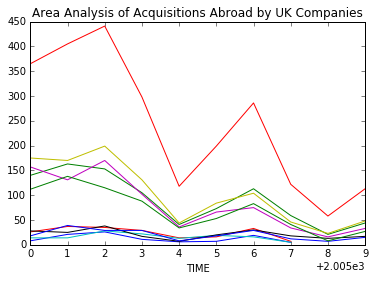

In [16]:
# alternatively, using pivot table (made by Peter)
import pandas as pd
df = ( 
    pd.DataFrame.from_records(allvalues)
    .rename(columns={-6:"MEASURETYPE", -2:"TIME", -9:"OBS"})
    .assign(TIME=lambda df:df.TIME.astype(int))
    #.assign(TIME2=lambda df:df.TIME.astype(int)*2)
)

pdf = df.pivot_table("OBS", ["TIME"], ["Mergers", "MEASURETYPE", "Area"])
# ["Area Analysis of Acquisitions Abroad by UK Companies"].xs("Number", level="MEASURETYPE", axis=1).plot()
acqtypes = pdf.columns.get_level_values(0).unique()
valtypes = pdf.columns.get_level_values(1).unique()

acqtype = acqtypes[0]
valtype = valtypes[0]
pdf[acqtype][valtype].plot(legend=False, title=acqtype)


In [ ]:
pdf[acqtype][valtype].plot